In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [3]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
from sklearn.covariance import EmpiricalCovariance
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score as clust_score
from sklearn.preprocessing import StandardScaler
from scipy import stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [4]:
pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
pl.rcParams['figure.dpi'] = 300 # dpi for most publications
pl.rcParams['xtick.labelsize'] = 7
pl.rcParams['ytick.labelsize'] = 7
pl.rcParams['axes.labelsize'] = 7
from ipywidgets import interact

# needs to find the library of functions
sys.path.append('../../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [5]:
# a double percentage sign indicates a magic function. in this case, now we are writing this cell in javascript.

In [6]:
NOTEBOOK_NAME = 'preprocessing'

In [7]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [8]:
data_folder = '../data'

In [9]:
traces = np.loadtxt(os.path.join(data_folder, 'C.txt')).T #denoised traces
traces_raw = np.loadtxt(os.path.join(data_folder, 'C_raw.txt')).T
try:
    areas = ut.load_spatial_footprints_A(os.path.join(data_folder, 'A.txt'))
except:
    print 'not 512 by 512'
events = np.loadtxt(os.path.join(data_folder, 'S.txt')).T
dff = np.loadtxt(os.path.join(data_folder, 'C_df.txt')).T
#mean_image, contours = ut.load_spatial_footprints(os.path.join(data_folder, 'Coor.mat'),
#                                                   os.path.join(data_folder, 'Cnn.txt'),
#                                                   key='coor')

#filename = os.path.join(data_folder, 'behavior.txt')

# adapting above code so we don't have to rename every arudino file to 'behavior.txt' when importing
for file in os.listdir(data_folder):
    if file.endswith("codes.txt"):
        filename = os.path.join(data_folder, file)
    elif 'behavior' in file:
        filename = os.path.join(data_folder, file)
print filename

behavior = ut.read_behavior(filename)
events_list = np.unique([b[1] for b in behavior])

../data/98_061822_D5_codes.txt


In [10]:
# grab time axis from the xml file

import xml.etree.ElementTree as ET
#xmlfile = os.path.join(data_folder, 'tseries.xml')

#adapting above code so we don't have to rename imported .xml file
for file in os.listdir(data_folder):
    if file.endswith("0.xml"):
        xmlfile = data_folder + '/' + file
print "I infer the time axis from:\n", xmlfile
tree = ET.parse(xmlfile)
root = tree.getroot()

# unfortunately we miss the first frame
time_ax = np.r_[[child.attrib['absoluteTime']
                 for child in root.iter('Frame')]].astype(float)

I infer the time axis from:
../data/TSeries-06182022-98-445um-3z-000.xml


In [11]:
time_ax

array([   49.858     ,    49.8910666 ,    49.92413319, ...,  2864.97729904,
        2865.0103737 ,  2865.04344835])

In [12]:
# sync times
start_2p = ut.parse_behavior(behavior, 'BEGIN')[0]
behavior = [[float(b[0])-start_2p, b[1]] for b in behavior]
time_ax -= time_ax[0]

In [13]:
# make sure presentations are correct in timing.
behavior[:10]

[[0.0, 'BEGIN'],
 [6.0, 'STIM1'],
 [8.5900000000000034, 'LICK'],
 [8.5900000000000034, 'LICK'],
 [9.382000000000005, 'LICK'],
 [9.3829999999999956, 'LICK'],
 [9.4440000000000026, 'LICK'],
 [9.4440000000000026, 'LICK'],
 [9.5049999999999955, 'LICK'],
 [9.5049999999999955, 'LICK']]

In [14]:
# clean up artefact events at the beginning of each cycle - will need for odors, but not sucrose and shock as
# suc and shock was continuous imaging
#for s, e in cycles:
#    if s>np.max(time_ax): break
#    events[np.where(time_ax>=s)[0][0]] = 0

In [15]:
##PLOTTING TRACES

# for i in range(traces.shape[1]):
    
#     fig, axs = pl.subplots(1, 1, figsize=(3, 2),)
#     pl.plot(time_ax, traces[:, i])
#     #pl.vlines(time_ax[np.nonzero(events[:, 0])], -2, 0, lw=1)

#     fig.savefig('../img/%s__traces_pre.pdf'%i)

In [16]:
print len(traces)
print len(time_ax)

7740
61926


In [17]:
#time_ax = time_ax[::6] # use this if video was averaged and need to adjust xml output to match

In [18]:
ratio = int(np.floor(time_ax.shape[0]/traces.shape[0]))
print ratio

8


In [19]:
time_ax = time_ax[::ratio] # use this if video was averaged and need to adjust xml output to match

In [20]:
print len(traces)
print len(time_ax)

7740
7741


In [21]:
time_ax = time_ax[0:len(traces)] # use this if any video frames were truncated (often need to do this a video is averaged)

In [22]:
print len(traces)
print len(time_ax)

7740
7740


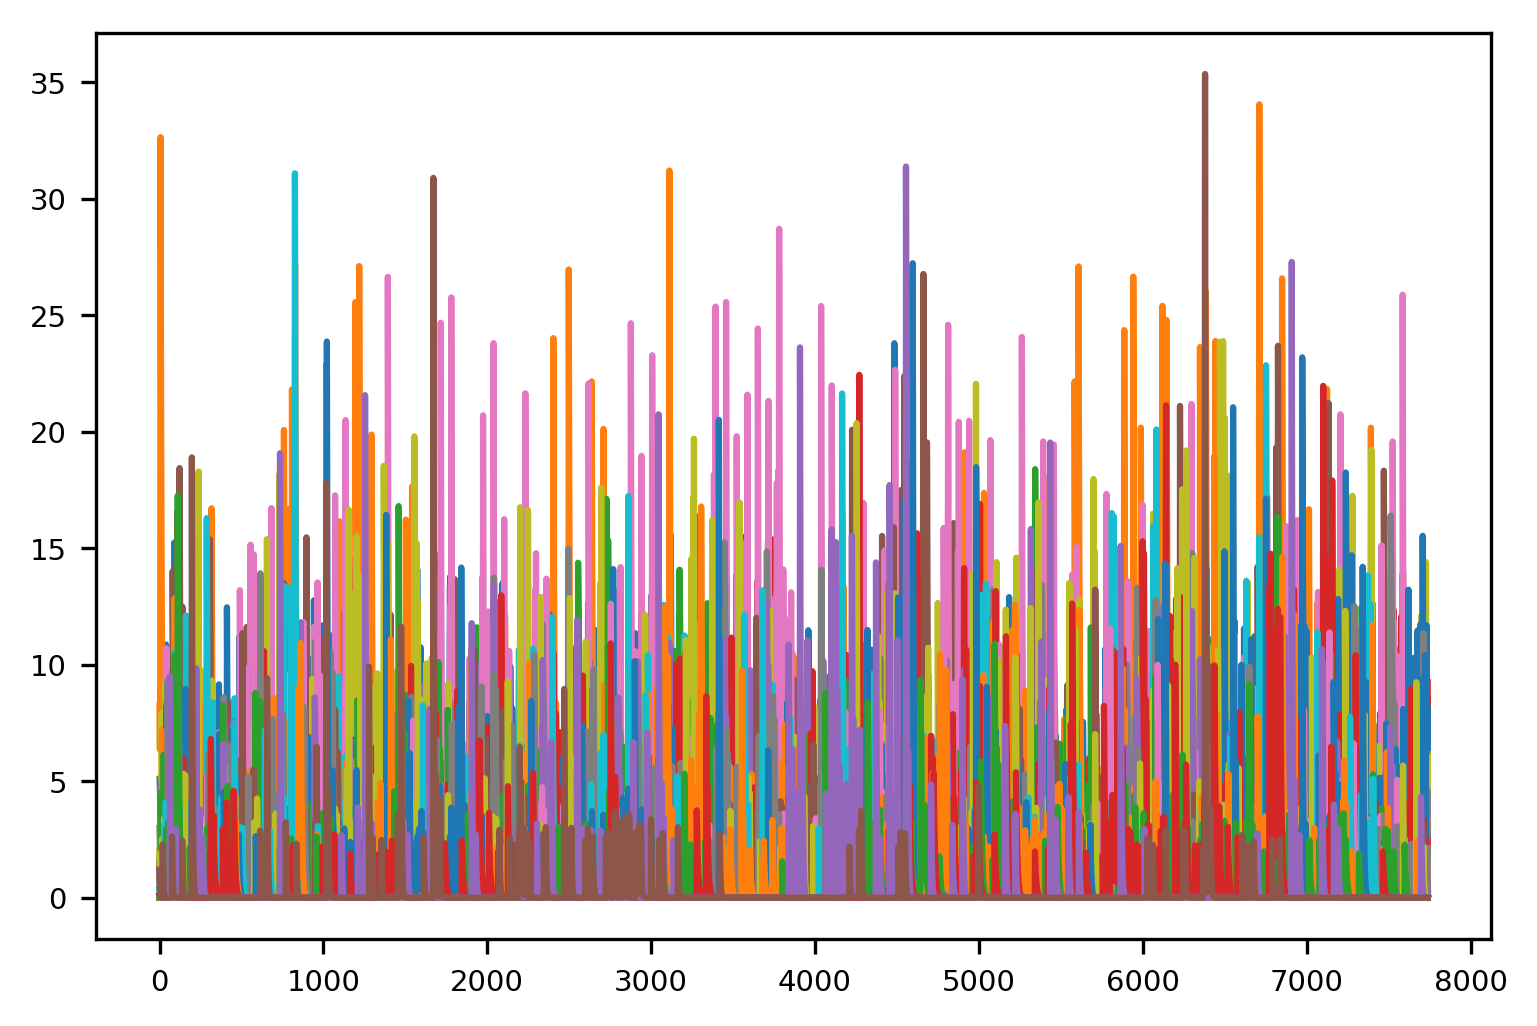

In [23]:
pl.plot(traces)

In [24]:
#to correct for different clocking speeds between arduino and 2p software
behavior = ut.sync_behavior_to_xml(time_ax, behavior)

[ 0.99588807  0.98030194  0.99594406  0.98040194  0.99592068  0.980366
  0.99593444  0.98037872  0.99600179  0.98038886  0.99595534  0.9803974
  0.9959598   0.98033706  0.9959576   0.98039582  0.99596516  0.98040958
  0.99597411  0.98040955  0.99597561  0.98041459  0.99597859  0.98035989
  0.99597853  0.98035636  0.99597453  0.98041749  0.99597923  0.9804199
  0.99592221  0.98042227  0.99598901  0.98042654  0.99599314  0.98037519
  0.99599699  0.98043754  0.99600525  0.98044376  0.99600214  0.98043902
  0.99600702  0.98044459  0.9960119   0.98044877  0.99600961  0.98044868
  0.99601009  0.980444    0.9960072   0.9804491   0.9960163   0.98045123
  0.99601223  0.98044886  0.99601561  0.98045855  0.9960206   0.98046264
  0.99602642  0.98045983  0.99602741  0.98046857  0.99597777  0.98047584
  0.99604057  0.9804804   0.99604274  0.98047418  0.99603377  0.98046961
  0.99603307  0.98046721  0.99608684  0.98046866  0.99603054  0.98046807
  0.99603217  0.98047207  0.99604087  0.98048135  0.996

In [25]:
# -----------------------------------------------------------
# these times are relative to the single cycle
# and centered around tone onset
CONTINUOUS = True
CYCLE_START = -5.5  # seconds
CS_DURATION = 2  # seconds  // IS THIS FIXED?
DELAY = 2
AFTER_DELAY_DURATION = 7
US_START = 4
CYCLE_DURATION = abs(CYCLE_START) + CS_DURATION + DELAY + AFTER_DELAY_DURATION

# -----------------------------------------------------------
# these times are absolute times, taken from the arduino file
STIM1_ons = np.r_[ut.parse_behavior(behavior, 'STIM1')]
STIM2_ons = np.r_[ut.parse_behavior(behavior, 'STIM2')]
STIM3_ons = np.r_[ut.parse_behavior(behavior, 'STIM3')]
STIM4_ons = np.r_[ut.parse_behavior(behavior, 'STIM4')]
STIM5_ons = np.r_[ut.parse_behavior(behavior, 'STIM5')]
STIM6_ons = np.r_[ut.parse_behavior(behavior, 'STIM6')]
STIM7_ons = np.r_[ut.parse_behavior(behavior, 'STIM7')]
STIM8_ons = np.r_[ut.parse_behavior(behavior, 'STIM8')]
CONTEXTA_ONLY_ons = np.r_[ut.parse_behavior(behavior, 'CONTEXTA_ONLY')]
CONTEXTB_ONLY_ons = np.r_[ut.parse_behavior(behavior, 'CONTEXTB_ONLY')]
#reward_CxA_CS1_ons = np.r_[ut.parse_behavior(behavior, 'CxA_US1_REWARD')]
#reward_CxB_CS1_ons = np.r_[ut.parse_behavior(behavior, 'CxB_US1_REWARD')]
#reward_CxA_CS2_ons = np.r_[ut.parse_behavior(behavior, 'CxA_US2_REWARD')]
#reward_CxB_CS2_ons = np.r_[ut.parse_behavior(behavior, 'CxB_US2_REWARD')]
rewards = np.r_[ut.parse_behavior(behavior, 'REWARD')]
licks = np.r_[ut.parse_behavior(behavior, 'LICK')]
#For times when sucrose reward is actually collected, see 'consumptions' variable created a few cell down



# -----------------------------------------------------------
# when the experiment starts and ends, in absolute time
# begin_end = ut.parse_behavior(behavior, '[be]')
# when each cycle starts and ends
# (last cycle is usually oddly recorded)
if CONTINUOUS:
    cycles_starts = ut.parse_behavior(behavior, ('STIM*'), offset=CYCLE_START) #looks for arduino line that begins w/ either O, R, S, or b
    cycles_ends = ut.parse_behavior(behavior, ('STIM*'), offset=CYCLE_DURATION+CYCLE_START)
else:
    cycles_starts = ut.parse_behavior(behavior, 'BEGIN')
    cycles_ends = ut.parse_behavior(behavior, 'END')
cycle_subtract = 0   #do we need to subtract off the last cycle because it's too short???
if cycle_subtract !=0:
    cycles = np.r_[zip(cycles_starts,  # offset will be ADDED, with sign
                   cycles_ends)][:cycle_subtract]
else:
    cycles = np.r_[zip(cycles_starts,  # offset will be ADDED, with sign
                   cycles_ends)]
print 'we are subtracting off this many cycles'
print cycle_subtract
# -----------------------------------------------------------
# which trials are of a certain US
is_STIM1t = [any(map(lambda t: (t>=s) and (t<e), STIM1_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM2t = [any(map(lambda t: (t>=s) and (t<e), STIM2_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM3t = [any(map(lambda t: (t>=s) and (t<e), STIM3_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM4t = [any(map(lambda t: (t>=s) and (t<e), STIM4_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM5t = [any(map(lambda t: (t>=s) and (t<e), STIM5_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM6t = [any(map(lambda t: (t>=s) and (t<e), STIM6_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM7t = [any(map(lambda t: (t>=s) and (t<e), STIM7_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM8t = [any(map(lambda t: (t>=s) and (t<e), STIM8_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_CONTEXTA_ONLYt = [any(map(lambda t: (t>=s) and (t<e), CONTEXTA_ONLY_ons)) for s, e in zip(cycles_starts, cycles_ends)]
is_CONTEXTB_ONLYt = [any(map(lambda t: (t>=s) and (t<e), CONTEXTB_ONLY_ons)) for s, e in zip(cycles_starts, cycles_ends)]

# now extract generalized trials
is_rewardt = [any(map(lambda t: (t>=s) and (t<e), rewards)) for s, e in zip(cycles_starts, cycles_ends)]
is_STIM3t_array = np.array(is_STIM3t)
is_STIM7t_array = np.array(is_STIM7t)
is_STIM4t_array = np.array(is_STIM4t)
is_STIM8t_array = np.array(is_STIM8t)
is_CSmt_array = is_STIM3t_array | is_STIM4t_array | is_STIM7t_array | is_STIM8t_array
is_CSmt = is_CSmt_array.tolist()
#is_CSmt = [any(map(lambda t: (t>=s) and (t<e), is_CSmt_list)) for s, e in zip(cycles_starts, cycles_ends)]


we are subtracting off this many cycles
0


In [26]:
licks = np.r_[ut.parse_behavior(behavior, 'LICK')]
licks_bs = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START-DELAY,
                                      end=-CYCLE_START)  # w.r.t. cycle start
licks_cs = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START,
                                      end=-CYCLE_START+CS_DURATION)
licks_tc = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START+CS_DURATION,
                                         end=-CYCLE_START+CS_DURATION+DELAY)
licks_cs_tc = 1.*ut.compute_licks_during(licks, cycles,
                                         start=-CYCLE_START,
                                         end=-CYCLE_START+CS_DURATION+DELAY)
licks_tc_us = 1.*ut.compute_licks_during(licks, cycles,
                                         start=-CYCLE_START+CS_DURATION,
                                         end=-CYCLE_START+CS_DURATION+DELAY+AFTER_DELAY_DURATION)
licks_cs_tc_us = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START,
                                      end=-CYCLE_START+CS_DURATION+DELAY+AFTER_DELAY_DURATION)
lickrates_bs = 1.*licks_bs/(DELAY+AFTER_DELAY_DURATION)
lick_ratios = np.nan_to_num(1.*(licks_tc_us-licks_bs)/(licks_tc_us+licks_bs))
lick_di = np.nan_to_num(1.*(np.mean(licks_tc[is_rewardt]-licks_bs[is_rewardt]) -
                            np.mean(licks_tc[is_CSmt]-licks_bs[is_CSmt]))/np.sqrt(0.5*(np.std(licks_tc)**2+np.std(licks_bs)**2)))
    
good_lick_trials = (licks_bs+licks_tc_us) >= 5

is_errCSmt = (lick_ratios>0.8) * ((licks_tc_us+licks_bs) > 4) * is_CSmt
print is_errCSmt.sum()

is_corrCSmt = ((licks_tc_us)==0) * is_CSmt
print is_corrCSmt.sum()

1
58


/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


In [48]:
time_ax_single = ut.extract_single_cycle_time_ax(time_ax, cycles,
                                                 cycle_duration=CYCLE_DURATION, cycle_start=CYCLE_START)

[63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 63, 62, 63, 62, 63, 62, 63, 62, 63, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 61]


array([[  4.75328407e-01,   1.69753284e+01],
       [  2.33914126e+01,   3.98914126e+01],
       [  4.93035264e+01,   6.58035264e+01],
       [  6.96780021e+01,   8.61780021e+01],
       [  9.06533813e+01,   1.07153381e+02],
       [  1.16203475e+02,   1.32703475e+02],
       [  1.39354464e+02,   1.55854464e+02],
       [  1.62513553e+02,   1.79013553e+02],
       [  1.87182011e+02,   2.03682011e+02],
       [  2.07821949e+02,   2.24321949e+02],
       [  2.29793732e+02,   2.46293732e+02],
       [  2.51711982e+02,   2.68211982e+02],
       [  2.75559617e+02,   2.92059617e+02],
       [  3.02208286e+02,   3.18708286e+02],
       [  3.26652746e+02,   3.43152746e+02],
       [  3.52360972e+02,   3.68860972e+02],
       [  3.72344791e+02,   3.88844791e+02],
       [  3.92880743e+02,   4.09380743e+02],
       [  4.15291704e+02,   4.31791704e+02],
       [  4.40600057e+02,   4.57100057e+02],
       [  4.61707713e+02,   4.78207713e+02],
       [  4.84999773e+02,   5.01499773e+02],
       [  

# Ignore this, Fabio

In [28]:
#establishes when the delivered sucrose was actually consumed by animal (first lick after delivery), wrt delivery time
consumption_times = []
for s, e in cycles[is_rewardt]:
    try:
        r = rewards[(rewards>=s)*(rewards<e)][0]
        later_licks = licks-r
        consumption_times.append(later_licks[(later_licks>=0)][0])
    except:
        consumption_times.append(np.nan)

In [29]:
consumption_times = np.r_[consumption_times]

In [30]:
#find trials where consumption took place at reasonable time following delivery
is_consumed = consumption_times<2

In [31]:
type(is_consumed)

numpy.ndarray

In [32]:
#find the absolute times when consumption takes place
consumptions = consumption_times + rewards

In [33]:
#when is US actually experienced by animal, wrt cycle timings?
US_offsets = np.concatenate([consumption_times])

In [34]:
#when is US experienced by animal, wrt time_ax?
US_perceptions = np.concatenate([(consumptions)])

In [35]:
save_workspace(db)

Could not store variable 'ET'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...


### 